# Numerical solution of 1d Poisson equation on the interval $[a,b]$:
\begin{align*}
  -u_{xx}  &= f, \qquad a < x < b \\
  u(a)&=g_0, \quad u(b) = g_1
\end{align*}
To simplify, we take $a=0$ and $b=1$.

## Code to solve the problem

* Import libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

* Function to construct tridiagonal matrices

In [2]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

* Construct a class for the BVP.

In [3]:
class BVP(object): 
    def __init__(self, f, g0=0, g1=0, a=0, b=1):
        self.f = f         # right hand side
        self.g0 = g0       # left boundary condition
        self.g1 = g1       # right boundary condition
        self.a = a         # left boundary position 
        self.b = b         # right boundary position

* Implement the solver. 

In [4]:
def solve_bvp(bvp, M=10):
    x = np.linspace(bvp.a, bvp.b, M+1)      # Gridpoints, including boundary points
    xi = x[1:-1]                            # Inner gridpoints
    h = (bvp.b-bvp.a)/M                     # Stepsize

    A = tridiag(-1, 2, -1, M-1)
    F = bvp.f(xi)*h**2                      
    F[0] = F[0] + bvp.g0
    F[-1] = F[-1] + bvp.g1

    # Solve the system of linear equations
    Ui = np.linalg.solve(A,F)

    # Include the boundary conditions:
    U = np.zeros(M+1)
    U[0] = bvp.g0
    U[1:-1] = Ui
    U[-1] = bvp.g1
    return x, U

## Run a numerical test

* Specify data for the problem.

In [5]:
def f(x):
    return (np.heaviside(x-0.25,1)-np.heaviside(x-0.75,1))*(10+np.sin(28*x)*30)
ex1 = BVP(f,g0=1,g1=0)

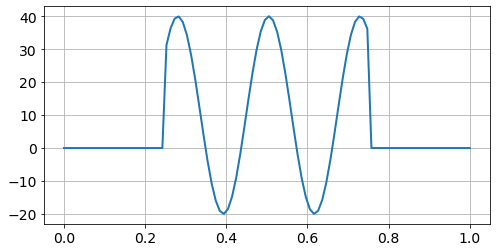

In [6]:
x = np.linspace(0,1,100)
plt.plot(x,f(x))

* Solve it. 
* Plot the solution.

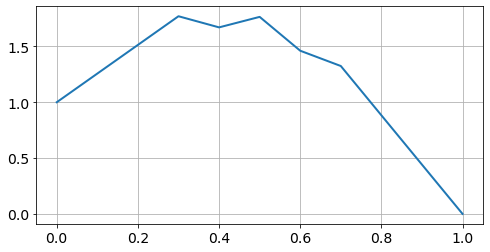

In [7]:
x, U = solve_bvp(ex1, M=10)
plt.plot(x,U)

* Refining the grid (reducing the step size) gives more accurate solutions.

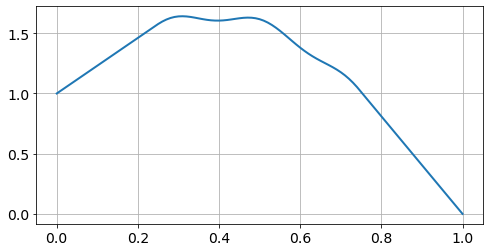

In [8]:
x, U = solve_bvp(ex1, M=100)
plt.plot(x,U)

## Test accuracy of solver. Manufactured solution.
* Here we force the exact solution to be $u=\sin 2x$
* We compute the corresponding $f$: $f(x)=-u_{xx}=4\sin 2x$...
* ... and use $u(0)=0$ and $u(1)=\sin 2$ as boundary values.

In [9]:
def u(x):
    return np.sin(2*x)
def f(x):
    return np.sin(2*x)*4
ex2 = BVP(f,g0=u(0),g1=u(1))

* Solve it. 
* Plot the solution.
* Compare with the exact solution (when available)

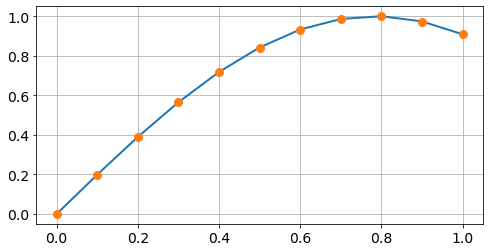

In [10]:
x, U = solve_bvp(ex2, M=10)
plt.plot(x,U);
plt.plot(x,u(x),'o')

* Plot the error

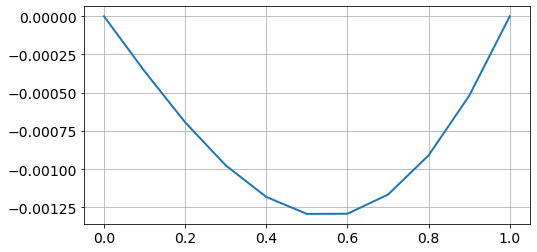

In [11]:
plt.plot(x,u(x)-U);

## Testing the convergence

* Verify the convergence result by successively refining the grid.  

* Make a table of values of $h$ versus values of the errors $e_h$.

* From the formula $e_h=Ch^p$ we have a linear dependence in log-log variables: $$\log e_h = p \log h + \log C.$$

* The experimental rate of convergence can then be computed for each refinement using the formula (subtract error formula for $e_i$ from the one for $e_{i-1}$): 

$
Rate_i = \dfrac{\log \frac{e_{h_{i-1}}}{e_{h_{i}}}}{\log \frac{h_{i-1}}{h_i}} 
$

* Add these rate to the table of errors.

In [12]:
def convergence(bvp, u_exact, solver=solve_bvp): 
    P = 8
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 10
    for p in range(P):                # Looping over refinement no's: p = 1 , ... P
        x, U = solver(bvp, M=M)           # Solve problem 
        Eh = u_exact(x)-U                 # Error vector 
        Econv[p] = np.max(np.abs(Eh))     # Max norm of error
        #Econv[p] = np.linalg.norm(Eh,ord=2)*np.sqrt(x[1]-x[0])
        Hconv[p] = x[1]-x[0]              # Step size
        M = 2*M                           # Doubling no of nodes for refinement no p+1
    order = np.polyfit(np.log10(Hconv),np.log10(Econv),1)[0]       # Linear regression on error values over all refinements
    return Hconv, Econv, order

In [13]:
H, E, p = convergence(ex2, u)

In [14]:
import pandas as pd #To format the output of the notebook.  
Rate=np.zeros(np.size(E))
Rate[1:]=np.log10(E[1:]/E[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.8f}'.format
#pd.set_option('display.float_format', '{:.2E}'.format)
df = pd.DataFrame(data={'h': H, 'Error': E ,'Rate':Rate}) 
df

,h,Error,Rate
0,0.10000000,0.00129199,0.00000000
1,0.05000000,0.00032607,1.98632192
2,0.02500000,0.00008149,2.00054111
3,0.01250000,0.00002037,2.00013526
4,0.00625000,0.00000509,2.00003382
5,0.00312500,0.00000127,2.00000840
6,0.00156250,0.00000032,2.00000262
7,0.00078125,0.00000008,1.99999678


* From the formula $e_h=Ch^p$ we have a linear dependence in log-log variables: $$\log e_h = p \log h + \log C.$$

* $p$ is then the slope of this line.

* An estimate of $p$ can also be found by linear regression on

| Log errors| $\log e_{h_1}$ | ... | $\log e_{h_P}$  |
| :--- | :--- | --- | :--- |
| Log step sizes | $\log h_1$     | ... | $\log {h_P}$    |

* Plot the refined $h$ and corresponding errors in a log-log plot (plot the table above) and corresponding regression line.

* OBS: The error bound is asymptotic and only holds for small enough $h$, and when $h$ is very small rounding error may dominate and reduce the rate. Depending your results, you therefore may have to exclude the least and/or most refined errors when computing the above regression (but not from the log-log table!).

* The error estimate computet in the lectures states that $$\|e_h\|_\infty \leq \frac 1 {96} K h^2,$$
where $K=\max_{x\in[0,1]}|u^{(4)}(x)|=2^4\sin \frac\pi2=16$ when $u=\sin 2x$.

* Also plot this bound.

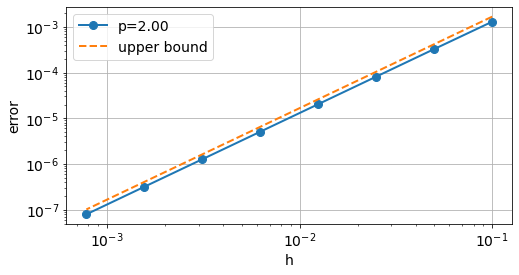

In [15]:
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.loglog(H,(H**2/96)*16,'--',label='upper bound')
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();

#### The observed error is better than the theoretical upper bound, and the rates are the same.